In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

##모델관련


## 데이터 확인

In [2]:
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape, val.shape, test.shape

((113842, 31), (28462, 32), (142503, 31))

In [4]:
print(train.columns)
print('=====================================================================================================')
print(val.columns)
print('=====================================================================================================')
print(test.columns)

Index(['ID', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30'],
      dtype='object')
Index(['ID', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30',
       'Class'],
      dtype='object')
Index(['ID', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30'],
      dtype='object')


In [5]:
print(train.info())
print('=====================================================================================================')
print(val.info())
print('=====================================================================================================')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113842 entries, 0 to 113841
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      113842 non-null  int64  
 1   V1      113842 non-null  float64
 2   V2      113842 non-null  float64
 3   V3      113842 non-null  float64
 4   V4      113842 non-null  float64
 5   V5      113842 non-null  float64
 6   V6      113842 non-null  float64
 7   V7      113842 non-null  float64
 8   V8      113842 non-null  float64
 9   V9      113842 non-null  float64
 10  V10     113842 non-null  float64
 11  V11     113842 non-null  float64
 12  V12     113842 non-null  float64
 13  V13     113842 non-null  float64
 14  V14     113842 non-null  float64
 15  V15     113842 non-null  float64
 16  V16     113842 non-null  float64
 17  V17     113842 non-null  float64
 18  V18     113842 non-null  float64
 19  V19     113842 non-null  float64
 20  V20     113842 non-null  float64
 21  V21     11

In [6]:
print(train.isnull().sum())
print('=====================================================================================================')
print(val.isnull().sum())
print('=====================================================================================================')
print(test.isnull().sum())

ID     0
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
dtype: int64
ID       0
V1       0
V2       0
V3       0
V4       0
V5       0
V6       0
V7       0
V8       0
V9       0
V10      0
V11      0
V12      0
V13      0
V14      0
V15      0
V16      0
V17      0
V18      0
V19      0
V20      0
V21      0
V22      0
V23      0
V24      0
V25      0
V26      0
V27      0
V28      0
V29      0
V30      0
Class    0
dtype: int64
ID     0
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
dtype: int64


- ID

- V1 ~ V30 : 개인정보로 공개되지 않은 값

- Class : 사기 여부 (1: 사기, 0: 정상)

### Train/Validation Feature 분포 확인

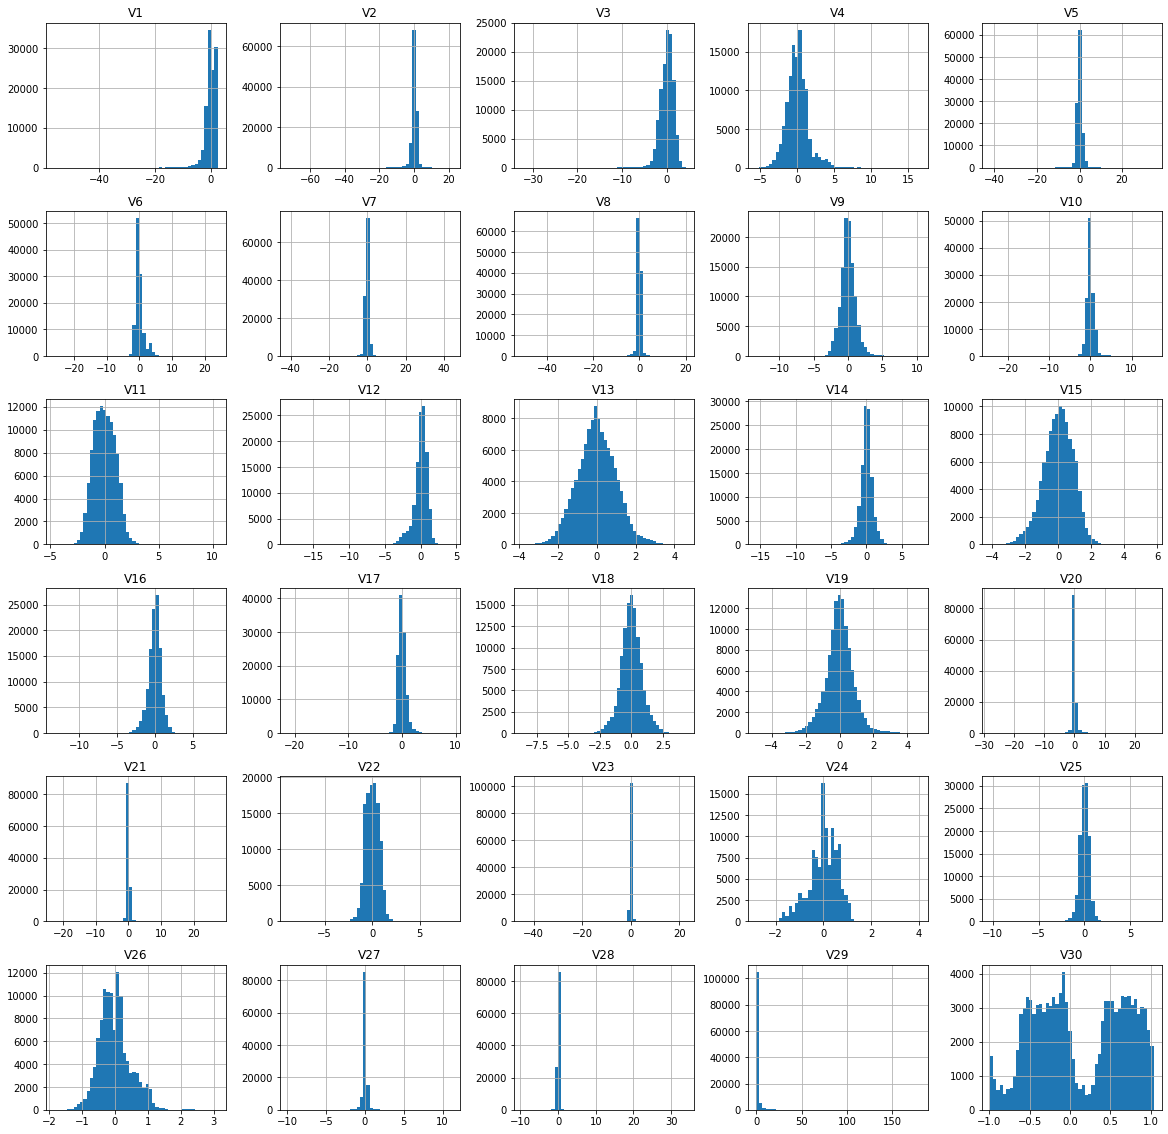

In [7]:
train.drop(columns=['ID']).hist(bins = 50, figsize = (20,20))
plt.show()

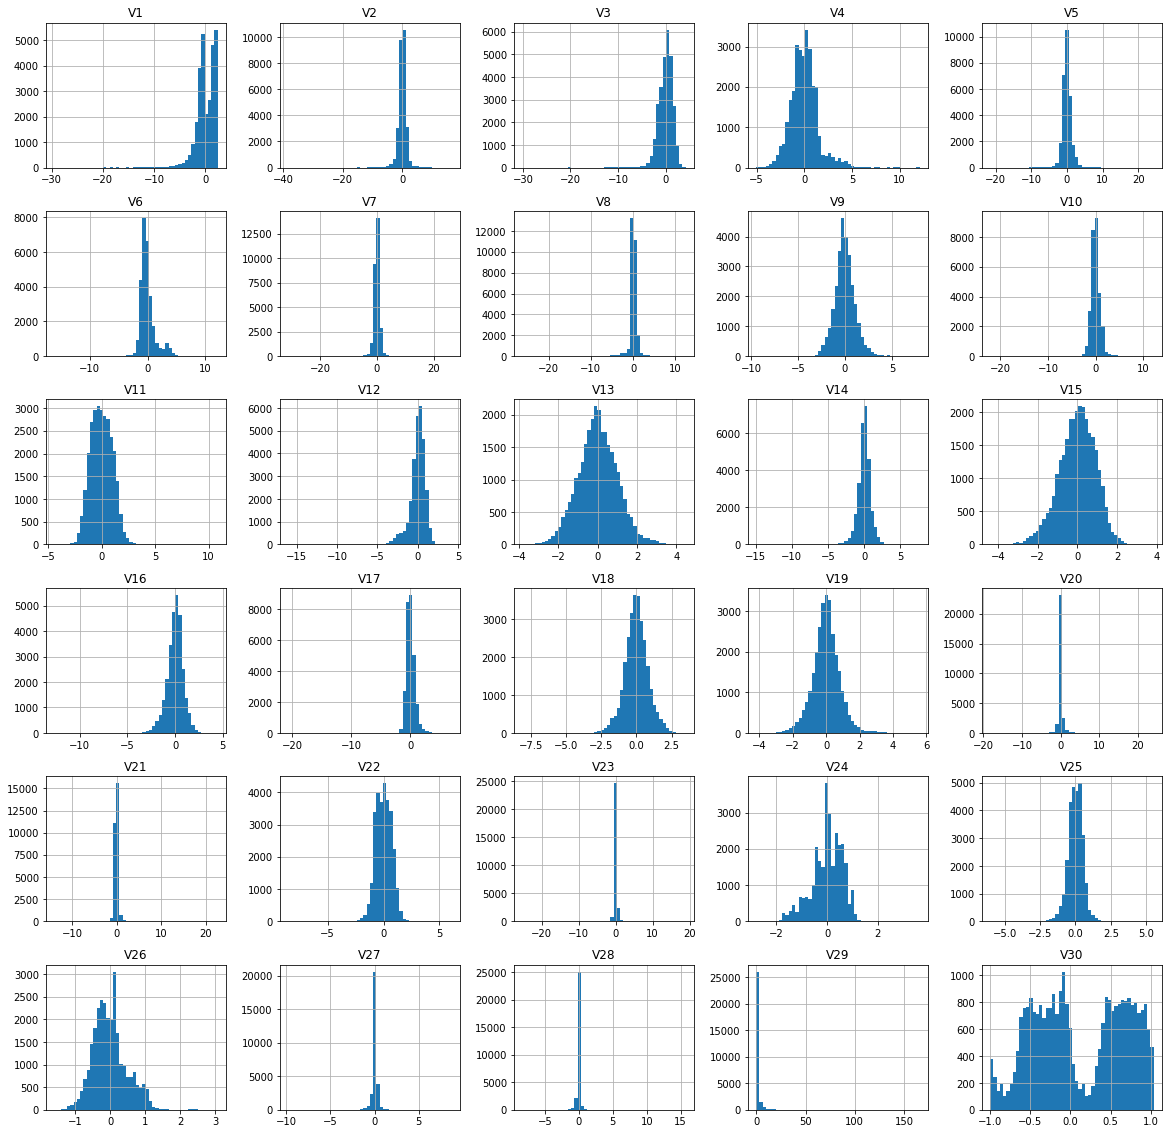

In [8]:
val.drop(columns=['ID', 'Class']).hist(bins = 50, figsize = (20,20))
plt.show()

### Validation set 사기 거래 비율

In [9]:
val['Class'].value_counts(normalize=True)

0    0.998946
1    0.001054
Name: Class, dtype: float64

=> 매우 불균형한 분포를 가지고 있다는 것을 확인
(일반적으로 사기 검출데이터는 적을 수 있기 때문)

=> 오버샘플링,,?

### 이상치 제거

In [10]:
val_x = val.drop(columns=['ID'])

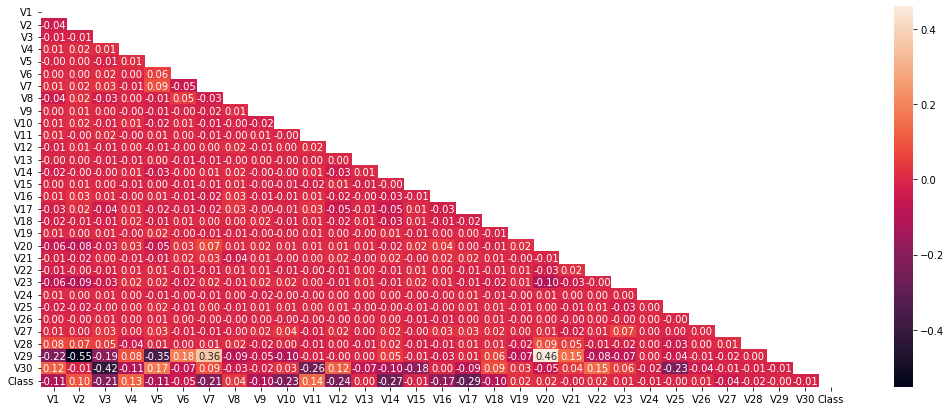

In [11]:
#상관계수 확인
plt.figure(figsize = (18, 7))
mask = np.triu(np.ones_like(val_x.corr(), dtype = np.bool))
sns.heatmap(val_x.corr(), annot = True, mask = mask, fmt = '0.2f')
plt.show()

=> Class 피처와 음의 상관관계가 높은 피처 - V17,V14


In [12]:
def get_outlier(df=None, column=None, weight=1.5):
    
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    # IQR을 구하고 IQR에 1.5를 곱해 최댓값과 최솟값 지점 도출
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최댓값보다 크거나 작은 값을 이상치로 설정
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [14]:
outlier_index = get_outlier(df=val_x, column='V17', weight=1.5)
print('아웃라이어 인덱스 : ', outlier_index)

아웃라이어 인덱스 :  Int64Index([], dtype='int64')


In [ ]:
val_x.drop(outlier_index, axis = 0, inplace = True)
val_x = val_x.drop(columns=['Class']) # Input Data
val_y = val['Class'] # Label

In [ ]:
train_x = train.drop(columns=['ID'])

### Modeling

In [ ]:
#가설 설정 : Train dataset도 Validation dataset과 동일한 비율로 사기거래가 발생했을 것이다.
##1.로지스틱회귀

# 가설 설정 : Train dataset도 Validation dataset과 동일한 비율로 사기거래가 발생 했을 것이다. -> model parameter : contamination=val_contamination(=0.001055) 적용
model = IsolationForest(n_estimators=125, max_samples=len(train_x), contamination = val_contamination, random_state=42, verbose=0)
model.fit(train_x)

In [ ]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [ ]:
val_pred = model.predict(val_x) # model prediction
val_pred = get_pred_label(val_pred)
val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))

In [ ]:
##2.LightGBM
# 본 데이터 세트는 불균형 레이블을 가져 boost_from_average를 False로 지정합니다.
# model2 = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=1, boost_from_average=False)
# model2.fit(train_x)

In [ ]:
# val_pred = model2.predict(val_x) # model prediction
# val_score = f1_score(val_y, val_pred, average='macro')
# print(f'Validation F1 Score : [{val_score}]')
# print(classification_report(val_y, val_pred))

### 테스트셋

In [ ]:
test = pd.read_csv('test.csv') # Train
test.head()

In [ ]:
test_x = test.drop(columns=['ID'])

In [ ]:
test_pred = model.predict(test_x) # model prediction
test_pred = get_pred_label(test_pred)

### Submit

In [ ]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

In [ ]:
submit['Class'] = test_pred
submit.to_csv('./submit.csv', index=False)